#Declarando as funções

# Link deste codigo no colab

https://colab.research.google.com/drive/1VVtZHlCvyaTF_tOQeQeAjTfJp_QASCnX?usp=sharing

# Funções de tratamento dos sinais

In [17]:
from matplotlib.pyplot import subplots, subplot, figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show, legend
from scipy.signal import kaiserord, lfilter, firwin,firwin2, freqz
from scipy.fft import fft, fftfreq
from urllib.request import urlopen
from IPython.display import Audio
from math import floor, sqrt
import soundfile as sf
import pandas as pd
import numpy as np
import io

def plotFilterCoefficients(taps):
  fig = figure(figsize=(20,5))
  ax1 = subplot(1,2,1)
  ax1.plot(taps, 'bo-', linewidth=2)
  ax1.set_title('Filter Coefficients')
  ax1.grid(True)

def plotFrequencyResponse(samplerate, taps, x0, x1, x2, x3):
  fig = figure(figsize=(20,5))
  ax2 = subplot(1,2,2)
  nyq_rate = samplerate / 2.0
  w, h = freqz(taps, worN=8000)

  ax2.plot((w/np.pi)*nyq_rate, np.absolute(h), linewidth=2)
  ax2.set_xlabel('Frequency (Hz)')
  ax2.set_ylabel('Gain')
  ax2.set_title('Frequency Response')
  ax2.set_ylim(-0.05, 1.05)
  ax2.grid(True)

  # Upper inset plot.
  ax3 = axes([0.64, 0.55, .25, .25])
  plot((w/np.pi)*nyq_rate, np.absolute(h), linewidth=2)
  xlim(x2, x3)
  ylim(0.997, 1.003)
  grid(True)

  # Lower inset plot
  ax4 = axes([0.64, 0.2, .25, .25])
  plot((w/np.pi)*nyq_rate, np.absolute(h), linewidth=2)
  xlim(x0, x1)
  ylim(0.0, 0.1)
  grid(True)

def plotSinalVSFiltro(data, taps, samplerate, filtered_data):
  fig, ax = subplots(figsize=(20,6), facecolor='#DEDEDE')

  fmax = samplerate//2 # // -> Divisão inteira, trunca para o menor inteiro mais proximo.
  tsamples = np.size(data[:,0],axis=0)//2

  x = np.linspace(0, fmax, tsamples)
  y = fft(data[:,0])[:tsamples]
  yf = fft(filtered_data[0:])[:tsamples]

  w, h = freqz(taps, worN=x, fs = samplerate)
  ymax = max([max(abs(y)), max(abs(yf))])
  line1, line2, line3 = ax.plot(np.real(x), abs(np.real(y/ymax)),"r",np.real(x), abs(np.real(yf/ymax)),"b",np.real(x), abs(h), 'g')
  legend([line1,line2, line3],["Normal","Filtrado", "filtro"]);

# Definindo os parâmetros do filtro
# fDBP       => Frequência em [Hz] Desejada para a Banda escolhida.
# ordem      => Ordem do Filtro.
# fs         => Frequência de Amostragem em [Hz].
# filterType => Tipo de filtro entre 'lowpass', 'highpass'
# desvio     => Máximo desvio da amplitude aceito na frequência desejada.
# isBP       => Frequência desejada é da banda de passagem "True" ou da Banda de Bloqueio "False"

def findFilterDigitalFir(fDesejada,ordem,fs,filterType="lowpass",desvio=0.05,isBP=True):
  faux      = fDesejada*(2*np.pi)/fs
  condition = (isBP if filterType=="lowpass" else not isBP)
  for fc in np.linspace(fDesejada, fs/2 if condition else 0, 10000, endpoint=False):
    taps = firwin(ordem, cutoff = fc,fs =fs, window = "hamming", pass_zero = filterType)
    w, h = freqz(taps, 1, worN=512)# Resposta em frequência do filtro
    hAux, wAux = (np.abs(h),np.abs(w)) if condition else (np.abs(h)[::-1], np.abs(w)[::-1])
    index = np.argmax(hAux<=(1-desvio) if isBP else hAux>=desvio)
    if ((wAux[index] >= faux) if condition else (wAux[index] <= faux)): break;

  fDInicio = (wAux*fs/(2*np.pi))[index]
  index = np.argmax(hAux<=desvio if isBP else hAux>=(1-desvio))
  fDFinal = (wAux*fs/(2*np.pi))[index]

  f = w*fs/(2*np.pi) #Transformando a frequência de rad/samples para Hz
  fig, ax1 = subplots(figsize=(20,6))
  ax1.set_xlabel('Frequência (Hz)')
  ax1.set_ylabel('Magnitude')
  ax1.plot(f, abs(h), 'b')
  display("Frequência limite da Banda de Passagem [Vermelho]: " + str(fDInicio if isBP else fDFinal));
  ax1.axvline(fDInicio if isBP else fDFinal,color='r');
  display("Frequência de corte [Verde]: " + str(fc));
  ax1.axvline(fc,color='g');
  display("Frequência limite da Banda de Bloqueio [Amarelo]: "+ str(fDFinal if isBP else fDInicio));
  ax1.axvline(fDFinal if isBP else fDInicio,color='y');
  ax1.grid()
  show()

  return taps

def diplayTaps(taps):
  display([h for h in taps])

# Caso 1: Voz em WAV

In [18]:
# drive.mount('/content/gdrive', force_remount=True)
data0, sample_rate0 = sf.read('./data/record.wav')
Audio(data0[:,0], rate=sample_rate0)

In [19]:
sample_rate0

48000

In [20]:
taps0 = firwin(59, cutoff = 2000,fs=sample_rate0, window = "hamming", pass_zero = "highpass") # Filtro passa Baixa (fc = 0.01fs) e pass_zero pode ser: bandpass, lowpass, highpass, bandstop
filtered_data0 = lfilter(taps0, 1.0, data0[:,0])
Audio(filtered_data0, rate=sample_rate0)

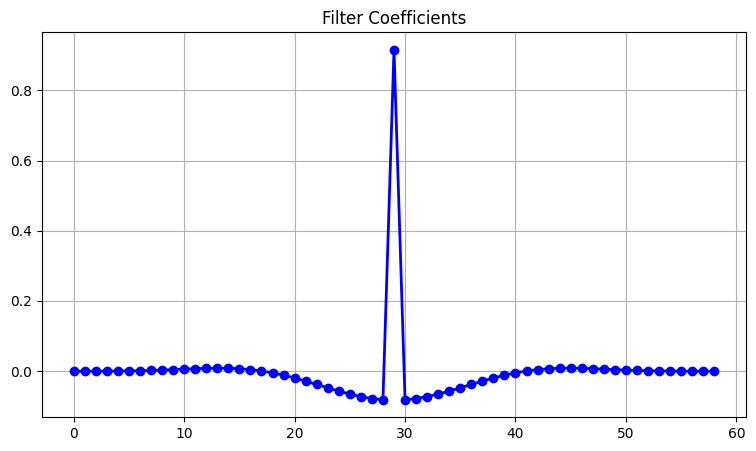

In [21]:
plotFilterCoefficients(taps0)

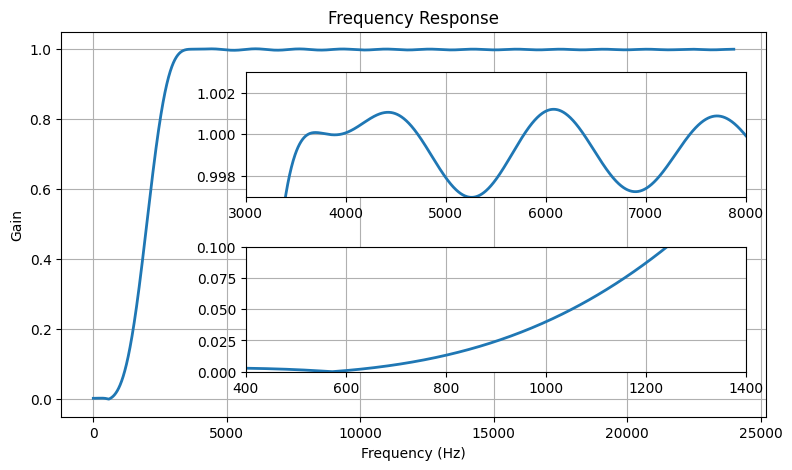

In [22]:
plotFrequencyResponse(sample_rate0, taps0, 400, 1400, 3000, 8000)

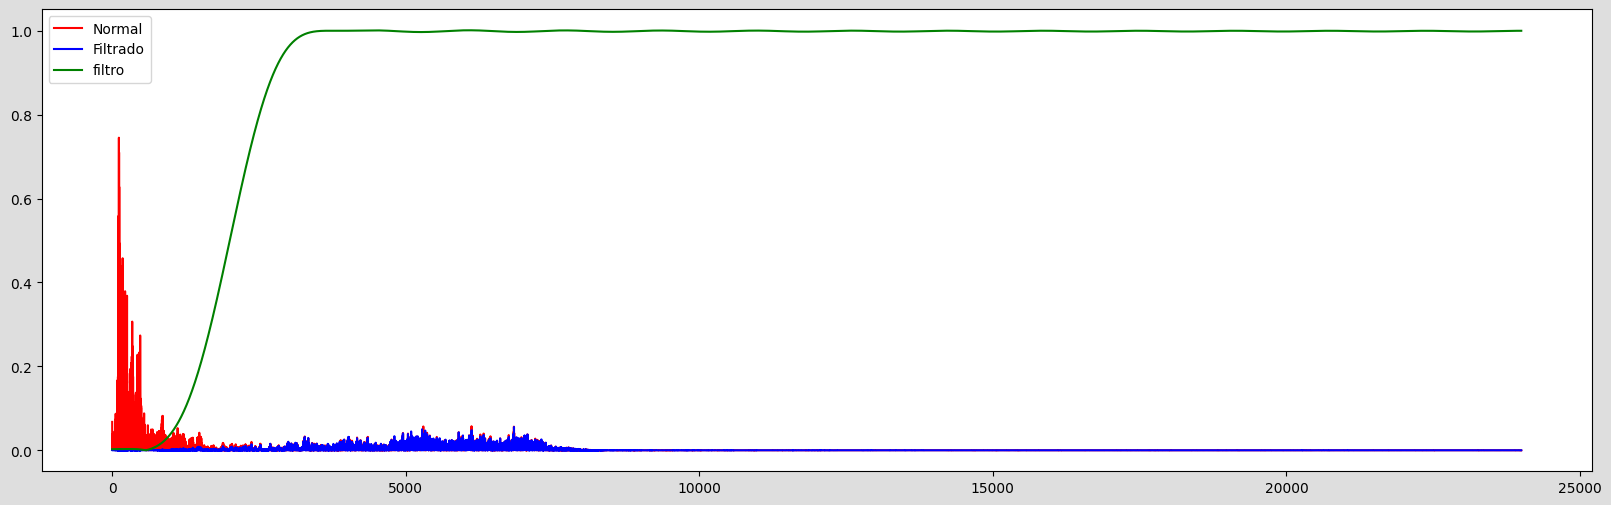

In [23]:
plotSinalVSFiltro(data0, taps0, sample_rate0, filtered_data0)

# Caso 2: Voz em OGG

In [24]:
data1, sample_rate1 = sf.read(io.BytesIO(urlopen("http://www.w3schools.com/html/horse.ogg").read()))
Audio(data1[:,0], rate=sample_rate1)

In [25]:
taps1 = firwin(33, cutoff = [700, 1400],fs=sample_rate1, window = "hamming", pass_zero = "bandpass") # Filtro passa Baixa (fc = 0.01fs) e pass_zero pode ser: bandpass, lowpass, highpass, bandstop
filtered_data1 = lfilter(taps1, 1.0, data1[:,0])
Audio(filtered_data1, rate=sample_rate1)

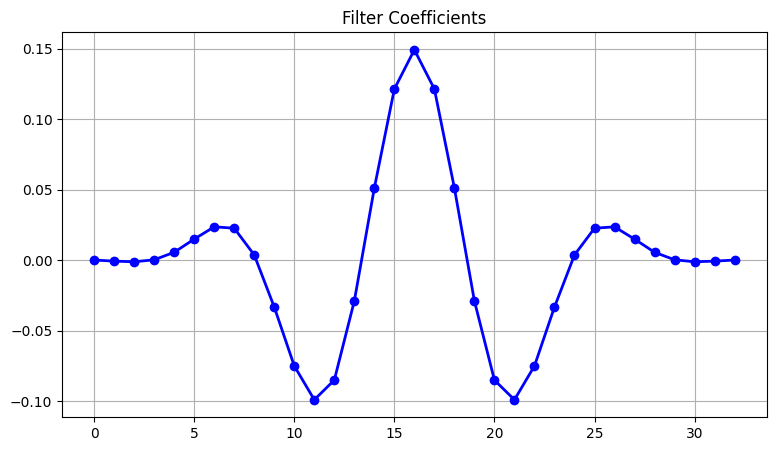

In [26]:
plotFilterCoefficients(taps1)

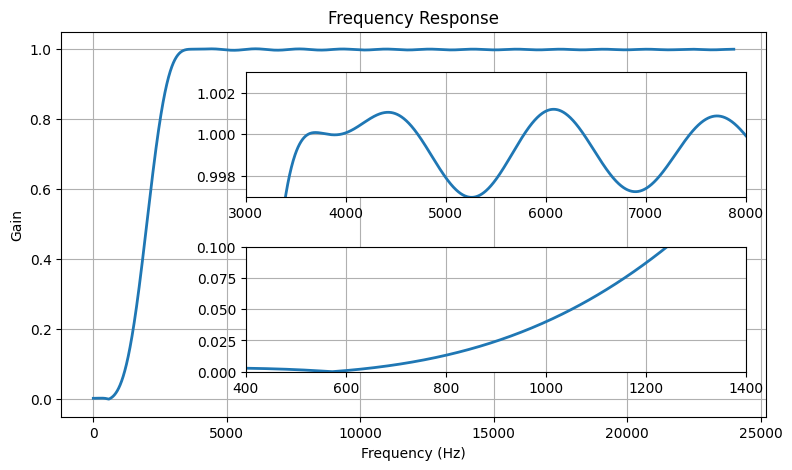

In [27]:
plotFrequencyResponse(sample_rate0, taps0, 400, 1400, 3000, 8000)

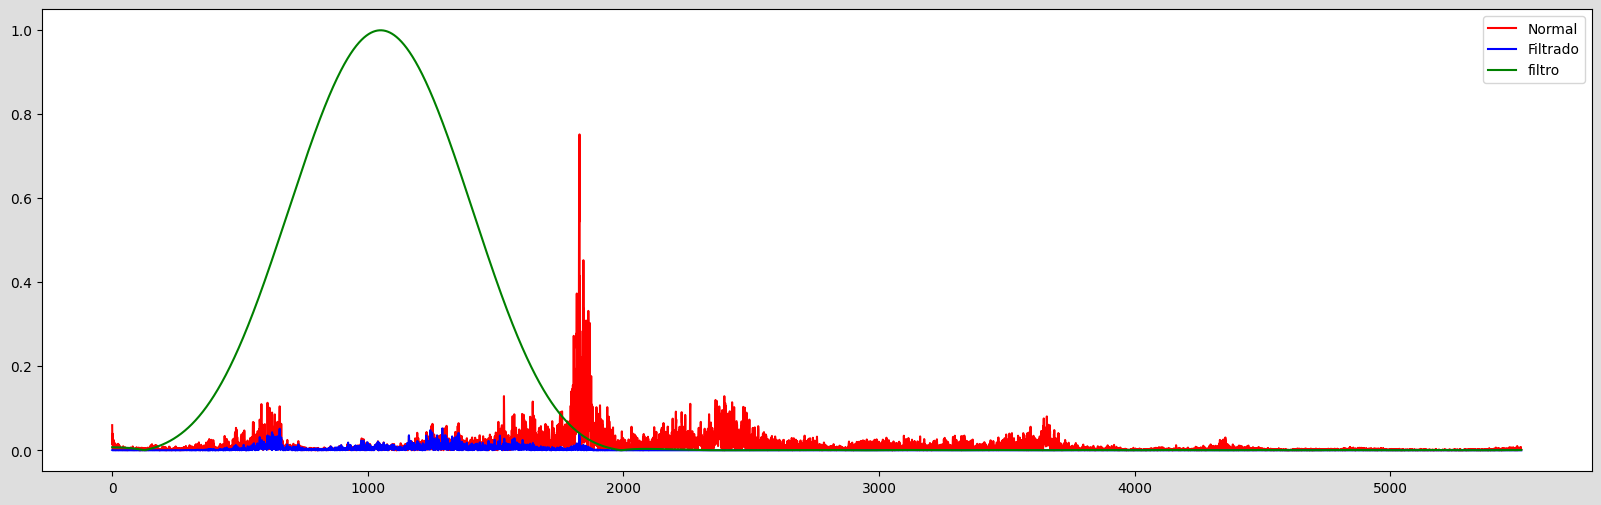

In [28]:
plotSinalVSFiltro(data1, taps1, sample_rate1, filtered_data1)

# Plotando a resposta em frequência do filtro

'Frequência limite da Banda de Passagem [Vermelho]: 29.980468750000004'

'Frequência de corte [Verde]: 27.789'

'Frequência limite da Banda de Bloqueio [Amarelo]: 25.48828125'

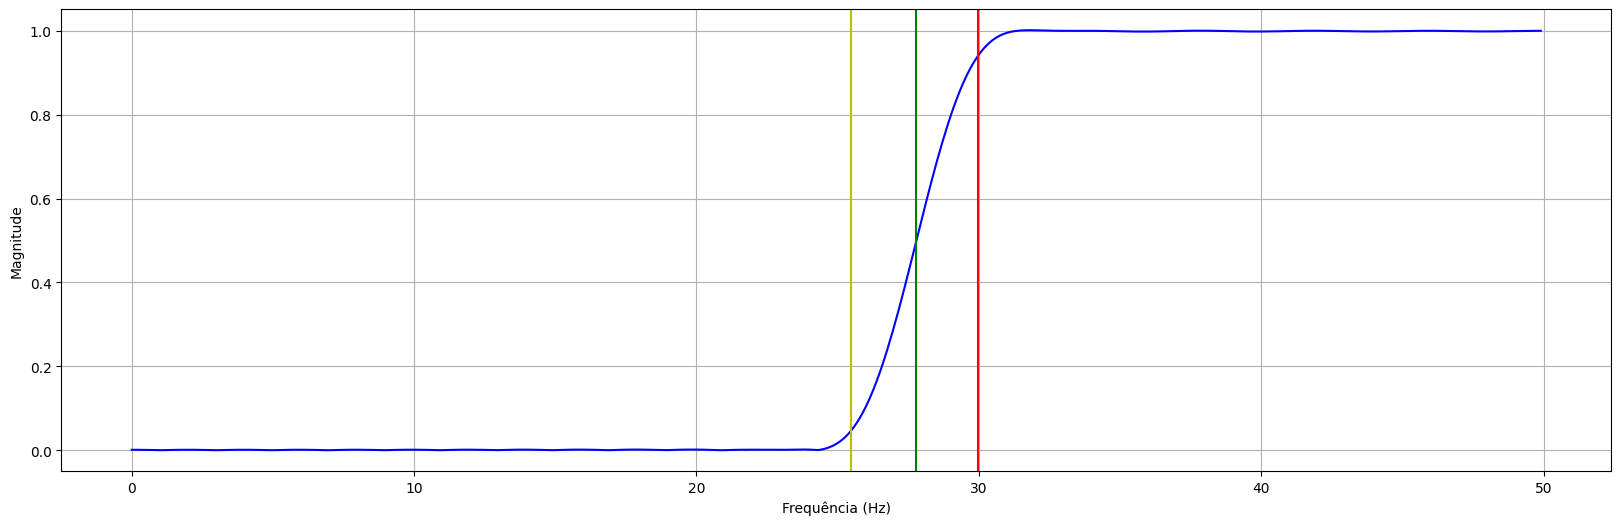

In [29]:
# Definindo os parâmetros do filtro
taps = findFilterDigitalFir(30,51,100,filterType="highpass",isBP=True)

In [30]:
diplayTaps(taps)

[np.float64(0.00033119919343607896),
 np.float64(0.0009690485393921891),
 np.float64(-0.0008232531614113261),
 np.float64(-0.0010628131745916004),
 np.float64(0.0017801323984055432),
 np.float64(0.0009482729372014539),
 np.float64(-0.003365990203040259),
 np.float64(-5.534563083717103e-05),
 np.float64(0.005419299243056855),
 np.float64(-0.002267166760165496),
 np.float64(-0.007350187752437025),
 np.float64(0.0065488500649859135),
 np.float64(0.008125722125057097),
 np.float64(-0.012994153839731333),
 np.float64(-0.0063245727756034665),
 np.float64(0.02134009869705668),
 np.float64(0.00016503181863706075),
 np.float64(-0.03082419587128722),
 np.float64(0.012773009107659081),
 np.float64(0.04028303603042116),
 np.float64(-0.037140607522501),
 np.float64(-0.04836586198180124),
 np.float64(0.0887431273760739),
 np.float64(0.05381411145318856),
 np.float64(-0.31205904194714645),
 np.float64(0.4438799748727083),
 np.float64(-0.3120590419471464),
 np.float64(0.05381411145318856),
 np.float64

'Frequência limite da Banda de Passagem [Vermelho]: 0.9765624999999999'

'Frequência de corte [Verde]: 4.701'

'Frequência limite da Banda de Bloqueio [Amarelo]: 9.765625'

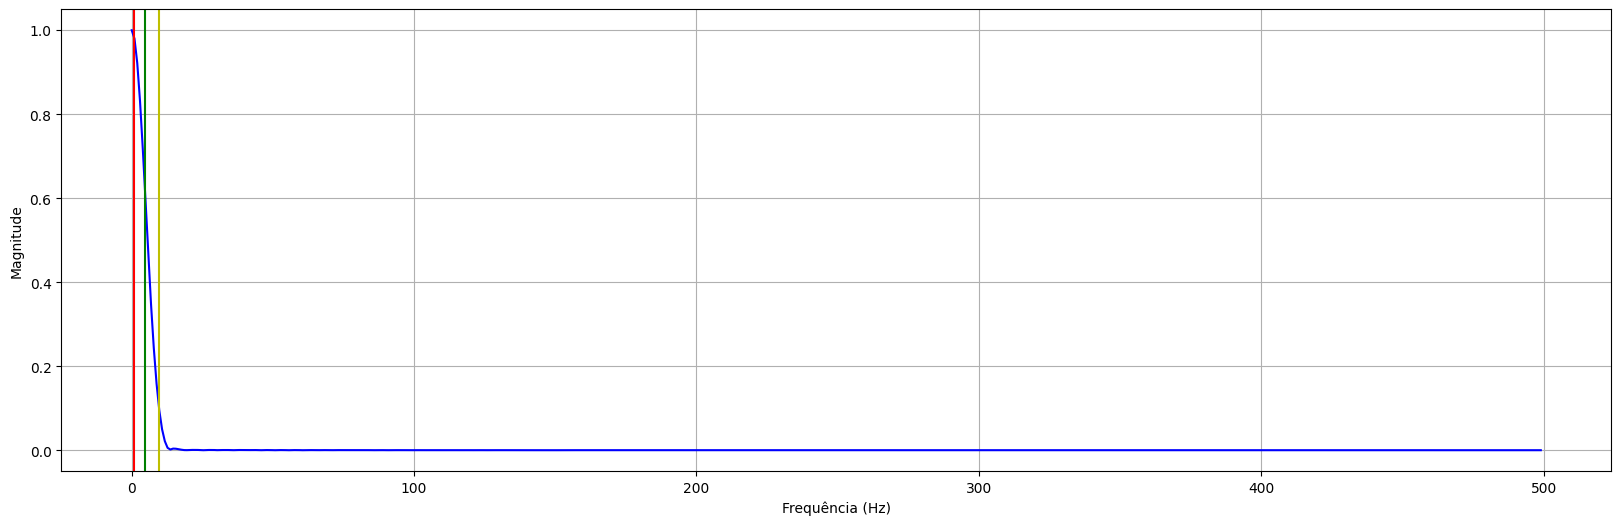

In [31]:
# Definindo os parâmetros do filtro
taps = findFilterDigitalFir(10,200,1000,'lowpass',isBP=False)

In [32]:
diplayTaps(taps)

[np.float64(6.336125424577913e-05),
 np.float64(7.338655762098165e-05),
 np.float64(8.40819945721434e-05),
 np.float64(9.561738801780399e-05),
 np.float64(0.00010816591442412033),
 np.float64(0.00012190356869662537),
 np.float64(0.0001370086131718814),
 np.float64(0.0001536610122941076),
 np.float64(0.000172041854618202),
 np.float64(0.00019233276383206208),
 np.float64(0.00021471530053755093),
 np.float64(0.00023937035657070247),
 np.float64(0.0002664775436776183),
 np.float64(0.0002962145783928862),
 np.float64(0.0003287566649920841),
 np.float64(0.00036427587840894026),
 np.float64(0.00040294054902091165),
 np.float64(0.00044491465121424114),
 np.float64(0.0004903571976409233),
 np.float64(0.0005394216410754006),
 np.float64(0.0005922552857682339),
 np.float64(0.0006489987101774259),
 np.float64(0.0007097852029355886),
 np.float64(0.0007747402138827161),
 np.float64(0.0008439808219601045),
 np.float64(0.0009176152217209441),
 np.float64(0.0009957422301674625),
 np.float64(0.00107845